In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line as sk_line
from scipy.ndimage import gaussian_filter  

In [3]:
def generate_neuron_stack(neuron_shapes, stack_shape, num_channels, noise_std, color_shift_std, saturation_level):
    """
    Simulates a Brainbow image stack.

    Parameters:
    - neuron_shapes: List of 3D binary arrays, each representing a neuron's structure.
    - stack_shape: Tuple (z, y, x) defining the stack's dimensions.
    - num_channels: Number of color channels.
    - noise_std: Standard deviation of Gaussian noise for the background.
    - color_shift_std: Standard deviation for the color variability within neurons.
    - saturation_level: Maximum intensity value for any voxel.

    Returns:
    - A simulated Brainbow stack with shape (num_channels, z, y, x).
    """
    stack = np.zeros((num_channels, *stack_shape), dtype=np.float32)

    for neuron in neuron_shapes:
        # Generate a random base color for the neuron
        base_color = np.random.uniform(0, 1, size=(num_channels,))
        
        # Add the neuron's color to the stack with Brownian color shifts
        for coord in np.argwhere(neuron):
            z, y, x = coord
            color_shift = np.random.normal(0, color_shift_std, size=(num_channels,))
            stack[:, z, y, x] += np.clip(base_color + color_shift, 0, 1)

    # Add Gaussian noise to the entire stack
    noise = np.random.normal(0, noise_std, size=stack.shape)
    stack += noise

    # Saturate intensities
    stack = np.clip(stack, 0, saturation_level)
    
    return stack

In [4]:
def load_swc(file_path):
    """
    Loads an SWC file and returns the points as a numpy array.
    Returns: array of shape (N, 3) containing (x, y, z) coordinates
    """
    points = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            data = line.strip().split()
            if len(data) == 7:  # Valid SWC format
                # SWC format: ID, type, x, y, z, radius, parent_id
                x, y, z = float(data[2]), float(data[3]), float(data[4])
                points.append([x, y, z])
    return np.array(points) 

In [5]:
def create_neuron_volume_from_swc(points, volume_shape, line_thickness=2):
    """
    Creates a 3D binary volume from SWC points using line drawing.
    """
    volume = np.zeros(volume_shape, dtype=np.bool_)
    
    # Extract parent-child relationships
    connections = {}
    for data in points:
        idx, _, x, y, z, _, parent = data
        idx = int(idx)
        parent = int(parent)
        if parent != -1:
            connections[idx] = parent
    
    # Draw each connection in 3D
    for idx, data in enumerate(points):
        if idx + 1 in connections:  # If this point has a child
            # Current point
            x1, y1, z1 = int(data[2]), int(data[3]), int(data[4])
            
            # Find parent point
            parent_data = points[connections[idx + 1] - 1]  # -1 for 0-based indexing
            x2, y2, z2 = int(parent_data[2]), int(parent_data[3]), int(parent_data[4])
            
            # Draw line between points
            for z in range(min(z1, z2), max(z1, z2) + 1):
                # Get 2D slice at this z-level
                rr, cc = sk_line(y1, x1, y2, x2)
                
                # Add thickness
                for offset_y in range(-line_thickness//2, line_thickness//2 + 1):
                    for offset_x in range(-line_thickness//2, line_thickness//2 + 1):
                        rr_thick = rr + offset_y
                        cc_thick = cc + offset_x
                        
                        # Keep only valid coordinates
                        mask = (rr_thick >= 0) & (rr_thick < volume_shape[1]) & \
                              (cc_thick >= 0) & (cc_thick < volume_shape[2])
                        if z >= 0 and z < volume_shape[0]:  # Check z bounds
                            volume[z, rr_thick[mask], cc_thick[mask]] = True
    
    return volume

In [6]:
def create_neuron_shapes_from_swc(swc_file, num_neurons, stack_shape):
    """
    Generates multiple copies of the SWC neuron with random rotations and positions.
    """
    # Load SWC data
    points = []
    with open(swc_file, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            data = line.strip().split()
            if len(data) == 7:
                points.append([float(x) for x in data])
    points = np.array(points)
    
    neurons = []
    
    # Center and normalize points
    points_xyz = points[:, 2:5]  # Extract x,y,z coordinates
    points_xyz = points_xyz - np.mean(points_xyz, axis=0)
    scale = np.max(np.abs(points_xyz)) * 2
    points[:, 2:5] = points_xyz * (min(stack_shape) / scale / 2)  # Scale coordinates
    
    for _ in range(num_neurons):
        # Random rotation matrix
        theta = np.random.rand() * 2 * np.pi
        phi = np.random.rand() * 2 * np.pi
        psi = np.random.rand() * 2 * np.pi
        
        Rx = np.array([[1, 0, 0],
                      [0, np.cos(theta), -np.sin(theta)],
                      [0, np.sin(theta), np.cos(theta)]])
        
        Ry = np.array([[np.cos(phi), 0, np.sin(phi)],
                      [0, 1, 0],
                      [-np.sin(phi), 0, np.cos(phi)]])
        
        Rz = np.array([[np.cos(psi), -np.sin(psi), 0],
                      [np.sin(psi), np.cos(psi), 0],
                      [0, 0, 1]])
        
        R = Rz @ Ry @ Rx
        
        # Create a copy of points for this neuron
        rotated_points = points.copy()
        
        # Rotate the x,y,z coordinates
        rotated_points[:, 2:5] = points_xyz @ R.T
        
        # Random translation to center area of volume
        translation = np.array([
            stack_shape[2]//4 + np.random.randint(0, stack_shape[2]//2),
            stack_shape[1]//4 + np.random.randint(0, stack_shape[1]//2),
            stack_shape[0]//4 + np.random.randint(0, stack_shape[0]//2)
        ])
        rotated_points[:, 2:5] += translation
        
        # Create volume
        neuron = create_neuron_volume_from_swc(rotated_points, stack_shape)
        neurons.append(neuron)
    
    return neurons 

In [7]:
def visualize_brainbow_combined(stack):
    """
    Visualizes all channels in a single image with unique colors.
    
    Parameters:
    - stack: 4D array (num_channels, z, y, x)
    """
    num_channels, z, y, x = stack.shape
    
    # Create a color map with distinct colors for each channel
    colors = [
        [1, 0, 0],      # Red
        [0, 1, 0],      # Green
        [0, 0, 1],      # Blue
        [1, 1, 0],      # Yellow
        [1, 0, 1],      # Magenta
        [0, 1, 1],      # Cyan
        [1, 0.5, 0],    # Orange
        [0.5, 0, 1],    # Purple
        [0, 1, 0.5],    # Lime
    ][:num_channels]    # Limit to number of channels
    
    # Initialize the combined image
    combined_image = np.zeros((y, x, 3), dtype=np.float32)
    
    # Add each channel with its corresponding color
    for channel_idx, color in enumerate(colors):
        # Get max projection of the channel
        channel_proj = np.max(stack[channel_idx], axis=0)
        # Normalize the projection
        channel_proj = channel_proj / channel_proj.max()
        # Add to the combined image with the specific color
        for c in range(3):  # RGB components
            combined_image[:, :, c] += channel_proj * color[c]
    
    # Normalize the final image
    combined_image = combined_image / combined_image.max()
    
    # Display
    plt.figure(figsize=(10, 5))
    plt.imshow(combined_image)
    plt.title("Combined Brainbow Visualization")
    plt.axis('off')
    plt.show(); 

In [8]:
# Parameters
stack_shape = (100, 200, 200)  # 3D stack dimensions (z, y, x)
num_neurons = 10               # Number of neurons to simulate
num_channels = 5              # Number of color channels
noise_std = 0.05              # Background noise standard deviation
color_shift_std = 0.1         # Color variability standard deviation
saturation_level = 1.0        # Maximum voxel intensity  

In [9]:
# Generate neuron shapes from SWC file
swc_file = "Image001-011_01_CNenhance_latest_CCG.swc"
neuron_shapes = create_neuron_shapes_from_swc(swc_file, num_neurons, stack_shape)  

In [10]:
brainbow_stack = generate_neuron_stack(neuron_shapes, stack_shape, num_channels, noise_std, color_shift_std, saturation_level)
print(brainbow_stack.shape)  

(5, 100, 200, 200)


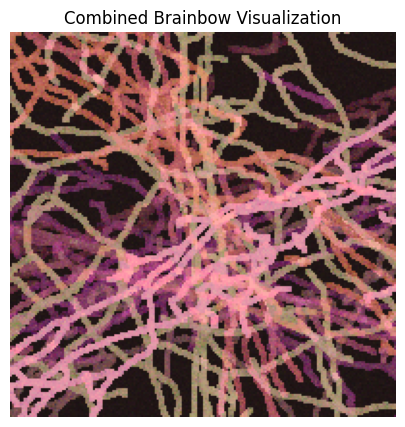

In [11]:
visualize_brainbow_combined(brainbow_stack) 